# Robot arm simulator

In this example a simulated IMU is attached to the end effector of a robot arm.
We use the [Robotics Toolbox for
Python](https://github.com/petercorke/robotics-toolbox-python) to simulate and
control the robot.

## Setup

The robot is a Franka Emika Panda, an earlier version of the current [Franka
Robotics Research 3](https://franka.de/).  A velocity controller moves the
gripper to a sequence of positions and orientations relative to its starting
position. The toolbox simulates the underlying kinematics at 100Hz. The pose of
the end effector forms the input for InertialSim.  The IMU is simulated in the
loop in `real-time` [mode](../reference/modes.md) for demonstration purposes.

## Simulate the robot

The robot is commanded to move its end effector through a series of four poses
relative to its initial position.  A highly damped velocity controller sets the
joint angles required to achieve each pose.  Once a pose is achieved the next
pose in the sequence is loaded.

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# This example is licensed under the CC BY-NC-SA 4.0 license.
# https://creativecommons.org/licenses/by-nc-sa/4.0/
# Email: info@inertialsim.com
#
# The Robotics Toolbox for Python code is modified from an example distributed
# under the MIT license.
# https://github.com/petercorke/robotics-toolbox-python
# -----------------------------------------------------------------------------
%matplotlib widget

import collections

import numpy as np

import roboticstoolbox as rtb
import spatialmath as sm
from swift import Swift

from inertialsim.devices.imu import bosch_bmi270
from inertialsim.geometry import Pose
from inertialsim.plot import TimeSeries
from inertialsim.sensors.imu import IMU, IMUModel
from inertialsim.geodesy import GlobalPose, ConstantGravity

env = Swift()
env.launch(headless=True)
# Uncomment for real-time interactive visualization
# env.launch(realtime=True, browser="notebook")

# Make a panda model and set its joint angles to the ready joint configuration
panda = rtb.models.Panda()
panda.q = panda.qr

# We need at least three positions to simulate accelerometer outputs so we use a
# double ended queue to accumulate them
poses = collections.deque(maxlen=3)

# Calculate the starting pose
current_pose = panda.fkine(panda.q)
poses.append(current_pose)

# Create a sequence of target end effector pose as offsets from the starting pose
target_poses = (
    current_pose
    * sm.SE3.Tx(0.1)
    * sm.SE3.Tz(0.2)
    * sm.SE3.Rz([0, np.pi / 2, 0, 0])
    * sm.SE3.Rx([-np.pi / 4, 0, np.pi / 4, 0])
)

# Add the robot to the simulator
env.add(panda)

# Create an IMU with default model settings and Bosch BMI270 specifications
imu = IMU(IMUModel(), bosch_bmi270, rng=0, mode="real-time", max_duration=600)

# Initialize simulation
time = 0.0
dt = 1.0 / bosch_bmi270.data_interface.sample_rate.value
measurements = []

# Simulate the robot
for target_pose in target_poses:
    arrived = False
    while not arrived:
        # Calculate the required end-effector velocity to go towards the goal
        velocity, arrived = rtb.p_servo(current_pose, target_pose, threshold=0.02)

        # Set the Panda's joint velocities
        panda.qd = np.linalg.pinv(panda.jacobe(panda.q)) @ velocity

        # Step the robot simulator
        env.step(dt)

        # Calculate and store the update pose
        current_pose = panda.fkine(panda.q)
        poses.append(current_pose)

        # To simulate IMU outputs with pose inputs we need at least 3 poses. Two
        # poses would be required if velocity inputs were also supplied.  We
        # overlap the pose inputs as (0,1,2), (2,3,4), (4,5,6), so that there
        # are no gaps in their numerical differences.
        if len(poses) == 3:
            # Create an intermediate geometric pose object
            pose = Pose.from_homogeneous_matrix(
                poses, time=[time - dt, time, time + dt]
            )

            # Convert it to a global pose object with the Robotics Toolbox
            # default gravity value
            global_pose = GlobalPose.from_local(
                pose=pose, gravity_model=ConstantGravity([0, 0, -9.81])
            )

            # Simulate the IMU
            measurement = imu.simulate(global_pose=global_pose)

            # Save the results and discard the two oldest poses
            measurements.append(measurement)
            poses.popleft()
            poses.popleft()

        time += dt


<video autoplay loop>
    <source src="../images/robot_arm.webm" type="video/webm">
</video>

## Plot simulated measurements

A [Bosch BMI270][inertialsim.devices.imu.bosch_bmi270] IMU is simulated.  The
measured angular rates (gyro) and specific forces (accelerometer) are first
collected into a single data structure and then plotted. Specific forces account
for gravity.  In this case, InertialSim uses a fixed value (`9.81 m/s/s`) that
matches the (non-standard) default in the Robotics Toolbox for Python
simulation.

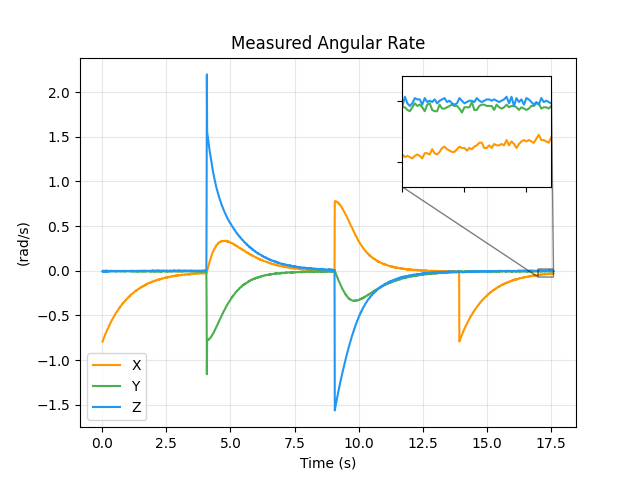

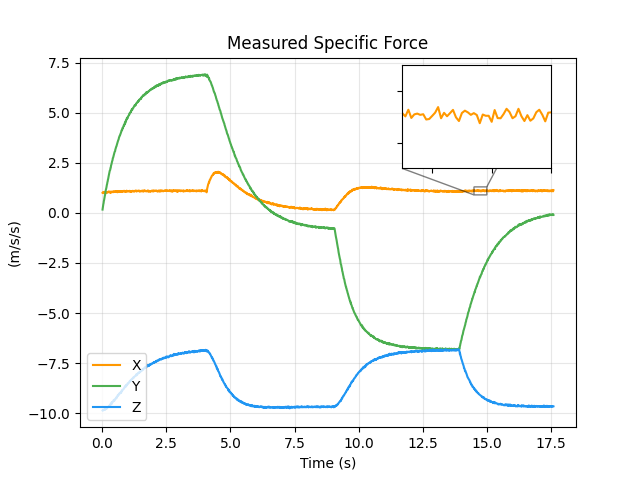

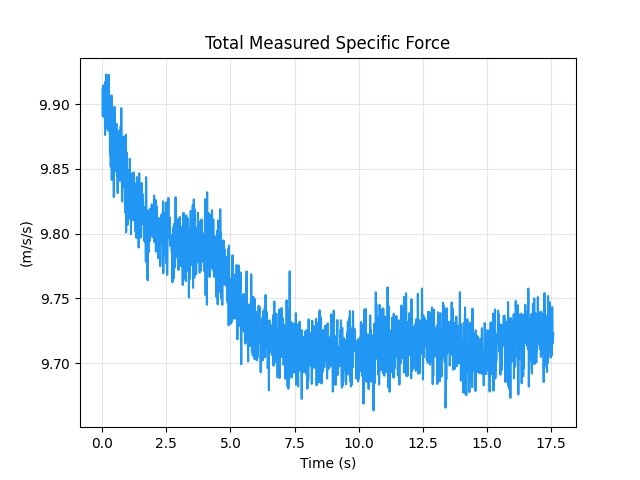

In [4]:
from inertialsim.sensors import Measurement

# Aggregate all the measurements
angular_rate = Measurement.from_measurements(
    [m.angular_rate[-2:] for m in measurements]
)
specific_force = Measurement.from_measurements(
    [m.specific_force[-2:] for m in measurements]
)

# Plot gyro data
w_plot = TimeSeries(title="Measured Angular Rate", ylabel="(rad/s)")
w_plot.line(angular_rate.time, angular_rate.data)
w_plot.zoom_inset([0.65, 0.65, 0.3, 0.3], [17, 17.6], [-0.07, 0.02])
w_plot.legend(["X", "Y", "Z"], loc="lower left")

# Plot accelerometer data
a_plot = TimeSeries(title="Measured Specific Force", ylabel="(m/s/s)")
a_plot.line(specific_force.time, specific_force.data)
a_plot.zoom_inset([0.65, 0.7, 0.3, 0.28], [14.5, 15], [0.9, 1.3])
a_plot.legend(["X", "Y", "Z"], loc="lower left")

# Plot total (3-axis normed) accelerometer data
g_plot = TimeSeries(title="Total Measured Specific Force", ylabel="(m/s/s)")
g_plot.line(
    specific_force.time, np.linalg.norm(specific_force.data, axis=1), color="#2196F3"
)

## Analyzing the result

Because the simulation is kinematic (no forces, torque, inertia or other
dynamics), the angular rate is able to respond almost instantaneously when new
pose targets are loaded.  A critically damped response to each new pose target
is visible in both gyro and accelerometer measurements.  The [Bosch
BMI270][inertialsim.devices.imu.bosch_bmi270] accelerometers are noisy and at
rest, measure an approximately `0.1 m/s/s` bias with respect to gravity (`9.72
m/s/s` measured v. `9.81 m/s/s` simulated).